## LSTM
This notebook outlines the process of implementing a univariate and multivariate Long Short Term Memory or LSTM model for Bitcoin Price Prediction.

According to the work of Nair et al., LSTM implementations outperformed a variety of other Deep Learning approaches for Bitcoin Price Prediction and reccomended testing this model with a multivariate approach, such as including twitter sentiment or other stock values. This will be attempted in this project and therefore the LSTM implementation will be kept as close to the Nair et al. implementation as possible.

The original implementation for the LSTM is well designed in the original paper and described below:
*  Step size of 7
*  First LSTM layer of 50 nodes (7,50) and a ReLU activation function
*  Second LSTM layer of 25 nodes (1,25) and a ReLU activation function
*  Fully connected (Dense) layer of 50 nodes.
*  Last fully connected (Dense) layer of 1 node - output.
*  Use of Adam optimizer - calculates the learning rate.

It is not clear which metric it optimizes on. The following adjustments will be made to the model:
*  Dropout layers will be added to prevent overfitting - this will be tuned.
*  Other Hyperparameters to be tuned include, choice of epoch and learning rate.

The main resources are as follows:
*  [Uni/Multivariate implementation guide](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
*  Time-Series LSTM Example [1](https://youtu.be/c0k-YLQGKjY?si=D2a0tmQtIY-h5LvZ) and [2](https://youtu.be/kGdbPnMCdOg?si=RxwW5Hxzd6PC3O2b) (VIDEOS)
[link text](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
*  Documentation [1](https://keras.io/api/layers/recurrent_layers/lstm/) and [2](https://www.tensorflow.org/tutorials/structured_data/time_series)
* M. Nair, M. I. Marie, and L. A. Abd-Elmegid, **"Prediction of Cryptocurrency Price Using Time Series Data and Deep Learning Algorithms,"** *International Journal of Advanced Computer Science and Applications* (IJACSA), vol. 14, no. 8, 2023.

In [ ]:
#uncomment these if required
#!pip install optuna
#!pip install codecarbon
#!pip install keras

In [ ]:
# Imports and Load File
from codecarbon import EmissionsTracker
tracker = EmissionsTracker(
    output_file='emissions_lstm.csv',
    project_name='lstm_implementation') #,country_iso_code="IE"
tracker.start()
# neccessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import optuna
from google.colab import drive
from google.colab import files
import sys
import joblib
import zipfile
import gc
gc.enable()

#setting seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#mount
drive.mount('/content/drive', force_remount=True)

#copy this file to the Colab Directory - alternatively: just download and upload directly
!cp '/content/drive/MyDrive/FILE_PATH/eval_metrics_cv.py' . #replace FILE_PATH with actual file path.
# Add the directory containing eval_metrics.py to the system path
sys.path.append('.')

from eval_metrics_cv import mae_calc, rmse_calc, smape_calc, rolling_cv
file_path = '/content/drive/My Drive/FILE_PATH'
#reading
df_1 = pd.read_csv(file_path + 'feature_engineered_data_1.csv', infer_datetime_format=True)
df_2 = pd.read_csv(file_path + 'feature_engineered_data_2.csv',infer_datetime_format=True)


[codecarbon WARNING @ 00:14:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:14:27] [setup] RAM Tracking...
[codecarbon INFO @ 00:14:27] [setup] CPU Tracking...
[codecarbon WARNING @ 00:14:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:14:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:14:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 00:14:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:14:28] [setup] GPU Tracking...
[codecarbon INFO @ 00:14:28] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:14:28] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Mounted at /content/drive


[codecarbon INFO @ 00:14:59] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:14:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:14:59] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 00:14:59] Energy consumed for all GPUs : 0.000094 kWh. Total GPU Power : 11.268257453801338 W
[codecarbon INFO @ 00:14:59] 0.000532 kWh of electricity used since the beginning.
<ipython-input-2-2cab54e93705>:40: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_1 = pd.read_csv(file_path + 'feature_engineered_data_1.csv', infer_datetime_format=True)
<ipython-input-2-2cab54e93705>:41: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A st

##Univariate Approach
Next, the data must be split allowing a sequence of data as input for the LSTM. LSTMs are capable of capturing the 'history' by defining the sequence size. In the case, the Close Price of Bitcoin will be split given a particular window size.

For example, if the size of 7 is given the input will be the Close value of the six days prior and the output will be the Close Value on the seventh day.
The prevents the model from seeing the future, and allows it to potentially capture temporal information.

In [ ]:
# creating the split or history for each point
def hist(sequence, n_steps):
  """
  Creates Input/Target Sequenecs for the Univariate Time Series Approach
  """
  X, y = list(), list()
  for i in range(len(sequence) - n_steps):
    seq_x = sequence[i:i + n_steps]
    seq_y = sequence[i + n_steps]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y) #np arrays for easier use in model an computation

In [ ]:
# apply to data
#univariate_data = df_1['Close_UTC_00'].to_numpy()

univariate_data = train_df_1['Close_UTC_00'].to_numpy()
#split into samples
n_steps = 7 #to match nair implementation
X_seq, y_seq = hist(univariate_data, n_steps)

#view to check
print(X_seq[:5])
print(y_seq[:5])

[[0.44860119 0.42966349 0.45300106 0.44592932 0.46686691 0.48195705
  0.46689478]
 [0.42966349 0.45300106 0.44592932 0.46686691 0.48195705 0.46689478
  0.47245206]
 [0.45300106 0.44592932 0.46686691 0.48195705 0.46689478 0.47245206
  0.47721196]
 [0.44592932 0.46686691 0.48195705 0.46689478 0.47245206 0.47721196
  0.47281696]
 [0.46686691 0.48195705 0.46689478 0.47245206 0.47721196 0.47281696
  0.45744274]]
[0.47245206 0.47721196 0.47281696 0.45744274 0.44733754]


Next we need to define custom fit and predict functions to match the rolling_cv implementation

In [ ]:
def lstm_univariate_fit(model_dict, X_train, y_train, n_steps=n_steps, epochs=50, dropout_rate=0.1, learning_rate=0.01):
  """
  Univariate LSTM using only pas Close Price as indicator
  """

  #3D Reshaping for LSTM [samples, window, features]
  X_shaped = X_train.reshape((X_train.shape[0], n_steps, 1))

  #Model Implementation:
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(25, activation='relu')) #(1,25)
  model.add(Dense(50, activation='relu')) #(50)
  model.add(Dropout(dropout_rate))
  model.add(Dense(1))#(1)
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='mae')

  #fit the model
  model.fit(X_shaped, y_train, epochs=epochs, verbose=0)
  #save model features
  model_dict['model'] = model
  model_dict['n_steps'] = n_steps
  return model_dict

def lstm_univariate_predict(model_dict, X_test):
  """
  Univariate LSTM using only pas Close Price as indicator
  """
  model = model_dict['model']
  n_steps = model_dict['n_steps']
  #3D Reshaping for LSTM [samples, window, features]
  X_shaped = X_test.reshape((X_test.shape[0], n_steps, 1))

  #make a prediction
  y_pred = model.predict(X_shaped, verbose=0).flatten()

  return y_pred

In [ ]:
#apply using rolling cv
model_dict = {}
results = rolling_cv(
    X_seq, y_seq,
    model=model_dict,
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: lstm_univariate_fit(model, X_train, y_train, n_steps=n_steps, epochs=50),
    custom_predict = lambda model, X_test: lstm_univariate_predict(model, X_test),
    return_preds=True
)
#print results
print(f"MAE: {results['mae']}")
print(f"RMSE: {results['rmse']}")
print(f"SMAPE: {results['smape']}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:15:14] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:15:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:15:14] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 00:15:14] Energy consumed for all GPUs : 0.000201 kWh. Total GPU Power : 25.669798335597697 W
[codecarbon INFO @ 00:15:14] 0.000857 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

MAE: 0.05348731494693063
RMSE: 0.058311249862422455
SMAPE: 36.25819752123666%


## Hyperparameter tuning using optuna
In order to optimize model performance, hyperparameter tuning using optuna was chosen. De to computational limitations, the number of trials had to be significantly reduced.

In [ ]:
#tune dropout rate, learning rate, metric to optimize adam on, num of epochs
gc.collect()
def objective(trial):
  #tune the hyperparams:
  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
  learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
  epochs = trial.suggest_int('epochs', 40, 80)

  model_dict = {}
  results = rolling_cv(
    X_seq, y_seq,
    model=model_dict,
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: lstm_univariate_fit(model, X_train, y_train, n_steps=n_steps, epochs=epochs, learning_rate=learning_rate, dropout_rate=dropout_rate),
    custom_predict = lambda model, X_test: lstm_univariate_predict(model, X_test),
    return_preds=False
)
  return results['mae']
#initialzing
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=4) #had to reduce due to computational resources

#save best params
best_params = study.best_params
print("Best Hyperparameters:")
print(best_params)

[I 2025-04-20 00:16:26,798] A new study created in memory with name: no-name-16d4965c-22cc-435d-af01-45485deec530
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:16:29] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:16:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:16:29] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 00:16:29] Energy consumed for all GPUs : 0.000902 kWh. Total GPU Power : 34.46041279534574 W
[codecarbon INFO @ 00:16:29] 0.002652 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:16:29] 0.007712 g.CO2eq/s mean an estimation of 243.2174099533797 kg.CO2eq/year
/usr/local/lib/python3.11/dist-packages

Best Hyperparameters:
{'dropout_rate': 0.147794616972786, 'learning_rate': 0.005701244878663035, 'epochs': 63}


The following were found to be the best for Dataset 1: `{'dropout_rate': 0.12317564259948291, 'learning_rate': 0.0019002012216125868, 'epochs': 60}`

The model was then refit with the held out test data and the predictions were extracted to get a view of an optimistic fit for the model.

In [ ]:
#fitting best model to the test set

univariate_data_test = refit_df_1['Close_UTC_00'].to_numpy()
#split into samples
n_steps = 7 #to match nair implementation
X_seq_test, y_seq_test = hist(univariate_data_test, n_steps)

#view to check
print(X_seq_test[:5])
print(y_seq_test[:5])

gc.collect()
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
epochs = best_params['epochs']

#buidling best model
X_shaped_test = X_seq_test.reshape((X_seq_test.shape[0], n_steps, 1))
model_best = Sequential()
model_best.add(LSTM(50, activation='relu', input_shape=(n_steps, 1), return_sequences=True)) #(7,50)
model_best.add(Dropout(dropout_rate))
model_best.add(LSTM(25, activation='relu')) #(1,25)
model_best.add(Dense(50, activation='relu')) #(50)
model_best.add(Dropout(dropout_rate))
model_best.add(Dense(1))#(1)
optimizer = Adam(learning_rate=learning_rate)
model_best.compile(optimizer=optimizer, loss='mae')

#fit
best_results = model_best.fit(X_shaped_test, y_seq_test, epochs=epochs, verbose=0)

[[0.93639071 0.9314441  0.89457092 0.89746225 0.88227405 0.86250501
  0.87332137]
 [0.9314441  0.89457092 0.89746225 0.88227405 0.86250501 0.87332137
  0.88030585]
 [0.89457092 0.89746225 0.88227405 0.86250501 0.87332137 0.88030585
  0.88415516]
 [0.89746225 0.88227405 0.86250501 0.87332137 0.88030585 0.88415516
  0.84177799]
 [0.88227405 0.86250501 0.87332137 0.88030585 0.88415516 0.84177799
  0.85210667]]
[0.88030585 0.88415516 0.84177799 0.85210667 0.85492833]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:22:29] Energy consumed for RAM : 0.001333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:22:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:22:29] Energy consumed for All CPU : 0.005664 kWh
[codecarbon INFO @ 00:22:29] Energy consumed for all GPUs : 0.004418 kWh. Total GPU Power : 37.84312773204888 W
[codecarbon INFO @ 00:22:29] 0.011415 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:22:29] 0.008581 g.CO2eq/s mean an estimation of 270.60582489735185 kg.CO2eq/year


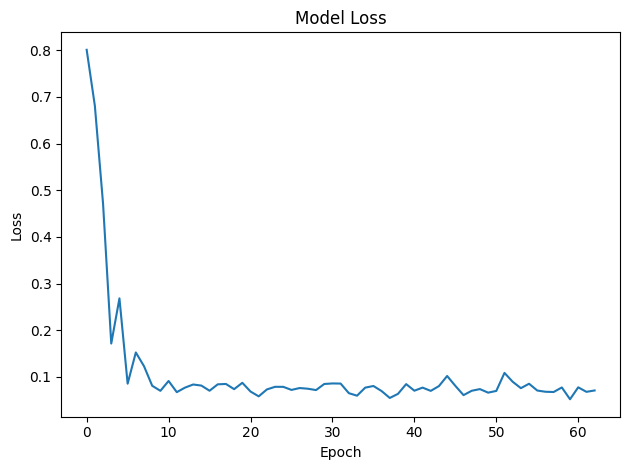

In [ ]:
#visualizations
#training loss
plt.plot(best_results.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('training_loss_plot_df_1.png')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 972ms/step


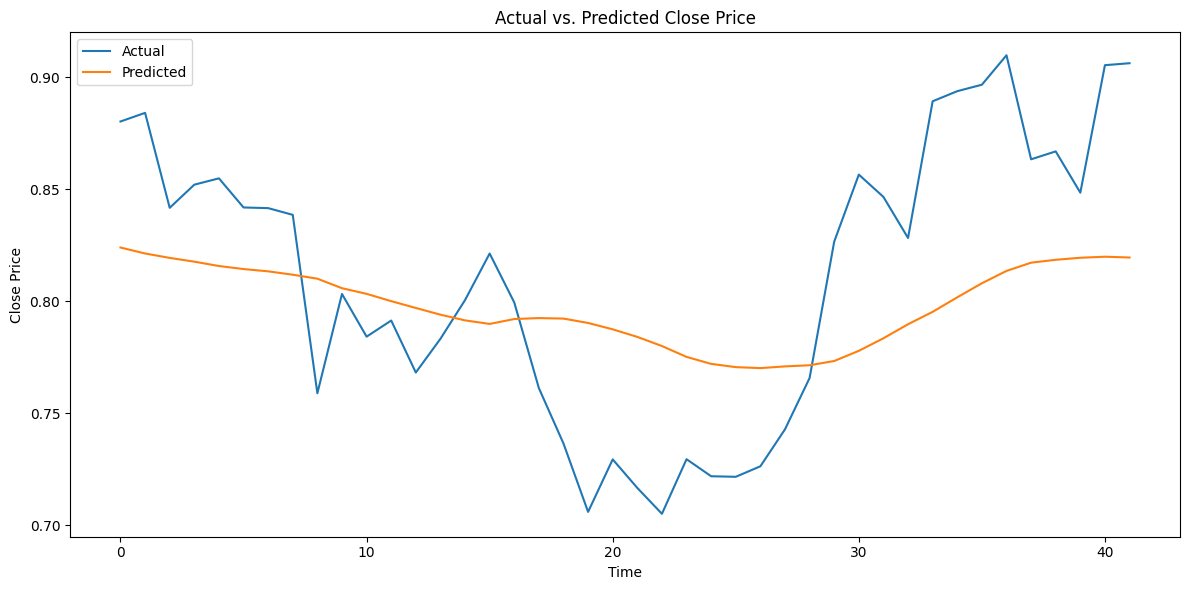

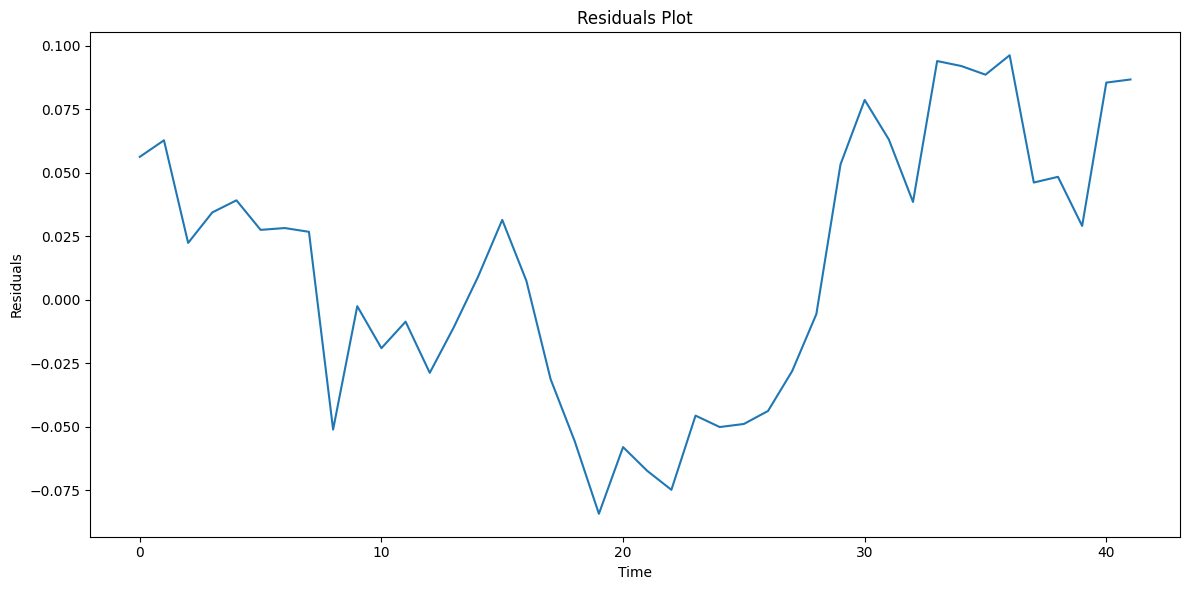

In [ ]:
#prediction and plot
y_pred = model_best.predict(X_shaped_test).flatten() #extracting the predicts
plt.figure(figsize=(12, 6))
plt.plot(y_seq_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.tight_layout()
plt.savefig('prediction_plot_df_1.png')
plt.show()

#plot residuals
residuals = y_seq_test - y_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.savefig('residuals_plot_df_1.png')
plt.show()

In [ ]:
#save model and parameters
with open('model_best_lstm_df_1.pkl', 'wb') as f:
    joblib.dump(model_best, f)
with open('best_params_lstm_df_1.pkl', 'wb') as f:
    joblib.dump(best_params, f)

# Dataset 2: Univariate Implementation and Hyperparameter Tuning.

In [ ]:
# apply to data
univariate_data_2 = train_df_2['Close_UTC_00'].to_numpy()

#split into samples
n_steps = 7 #to match nair implementation
X_seq, y_seq = hist(univariate_data_2, n_steps)

In [ ]:
#apply using rolling cv
model_dict = {}
results = rolling_cv(
    X_seq, y_seq,
    model=model_dict,
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: lstm_univariate_fit(model, X_train, y_train, n_steps=n_steps, epochs=50),
    custom_predict = lambda model, X_test: lstm_univariate_predict(model, X_test),
    return_preds=True
)
#print results
print(f"MAE: {results['mae']}")
print(f"RMSE: {results['rmse']}")
print(f"SMAPE: {results['smape']}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:22:44] Energy consumed for RAM : 0.001374 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:22:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:22:44] Energy consumed for All CPU : 0.005842 kWh
[codecarbon INFO @ 00:22:44] Energy consumed for all GPUs : 0.004574 kWh. Total GPU Power : 37.417285576808396 W
[codecarbon INFO @ 00:22:44] 0.011790 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

MAE: 0.03651156185099573
RMSE: 0.04639294941446319
SMAPE: 9.871013649381498%


In [ ]:
#tune dropout rate, learning rate, metric to optimize adam on, num of epochs
gc.collect()
def objective(trial):
  #tune the hyperparams:
  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
  learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
  epochs = trial.suggest_int('epochs', 40, 80)

  model_dict = {}
  results = rolling_cv(
    X_seq, y_seq,
    model=model_dict,
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: lstm_univariate_fit(model, X_train, y_train, n_steps=n_steps, epochs=epochs, learning_rate=learning_rate, dropout_rate=dropout_rate),
    custom_predict = lambda model, X_test: lstm_univariate_predict(model, X_test),
    return_preds=False
)
  return results['mae']
#initialzing
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=4)

#save best params
best_params = study.best_params
print("Best Hyperparameters:")
print(best_params)

[I 2025-04-20 00:23:34,193] A new study created in memory with name: no-name-47c5a40e-4e36-45f8-9bf1-3de58cfae1d2
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:23:44] Energy consumed for RAM : 0.001541 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:23:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:23:44] Energy consumed for All CPU : 0.006550 kWh
[codecarbon INFO @ 00:23:44] Energy consumed for all GPUs : 0.005188 kWh. Total GPU Power : 34.91184634878693 W
[codecarbon INFO @ 00:23:44] 0.013278 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a 

Best Hyperparameters:
{'dropout_rate': 0.11496040907691772, 'learning_rate': 0.002639069415734064, 'epochs': 58}


The optimal hyperparameters for Dataset 2: `{'dropout_rate': 0.3342959513011574, 'learning_rate': 0.00658522373198727, 'epochs': 65}`

In [ ]:
#fitting best model
gc.collect()
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
#metric = best_params['metric']
epochs = best_params['epochs']


univariate_data_test = refit_df_2['Close_UTC_00'].to_numpy()
#split into samples
n_steps = 7 #to match nair implementation
X_seq_test, y_seq_test = hist(univariate_data_test, n_steps)

#view to check
print(X_seq_test[:5])
print(y_seq_test[:5])



#buidling best model
X_shaped_test = X_seq_test.reshape((X_seq_test.shape[0], n_steps, 1))
model_best = Sequential()
model_best.add(LSTM(50, activation='relu', input_shape=(n_steps, 1), return_sequences=True)) #(7,50)
model_best.add(Dropout(dropout_rate))
model_best.add(LSTM(25, activation='relu')) #(1,25)
model_best.add(Dense(50, activation='relu')) #(50)
model_best.add(Dropout(dropout_rate))
model_best.add(Dense(1))#(1)
optimizer = Adam(learning_rate=learning_rate)
model_best.compile(optimizer=optimizer, loss='mae')

#fit
best_results = model_best.fit(X_shaped_test, y_seq_test, epochs=epochs, verbose=0)

[[0.199339   0.1272299  0.10780311 0.1002482  0.08606901 0.07918747
  0.03609165]]
[0.07252713]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:27:59] Energy consumed for RAM : 0.002249 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:27:59] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:27:59] Energy consumed for All CPU : 0.009559 kWh
[codecarbon INFO @ 00:27:59] Energy consumed for all GPUs : 0.007694 kWh. Total GPU Power : 35.54376640332397 W
[codecarbon INFO @ 00:27:59] 0.019502 kWh of electricity used since the beginning.


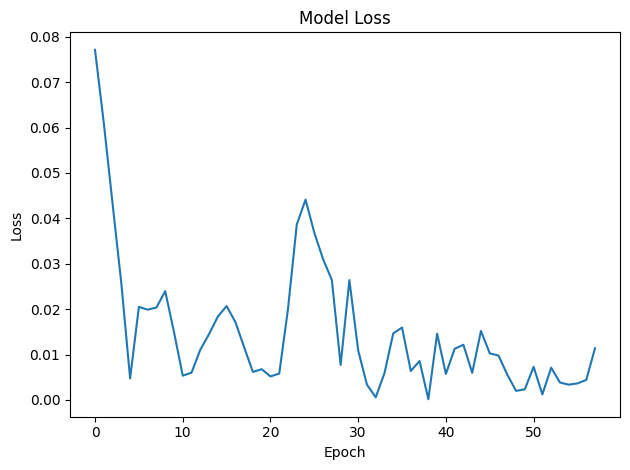

In [ ]:
#visualizations
#training loss
plt.plot(best_results.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('training_loss_plot_df_2.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


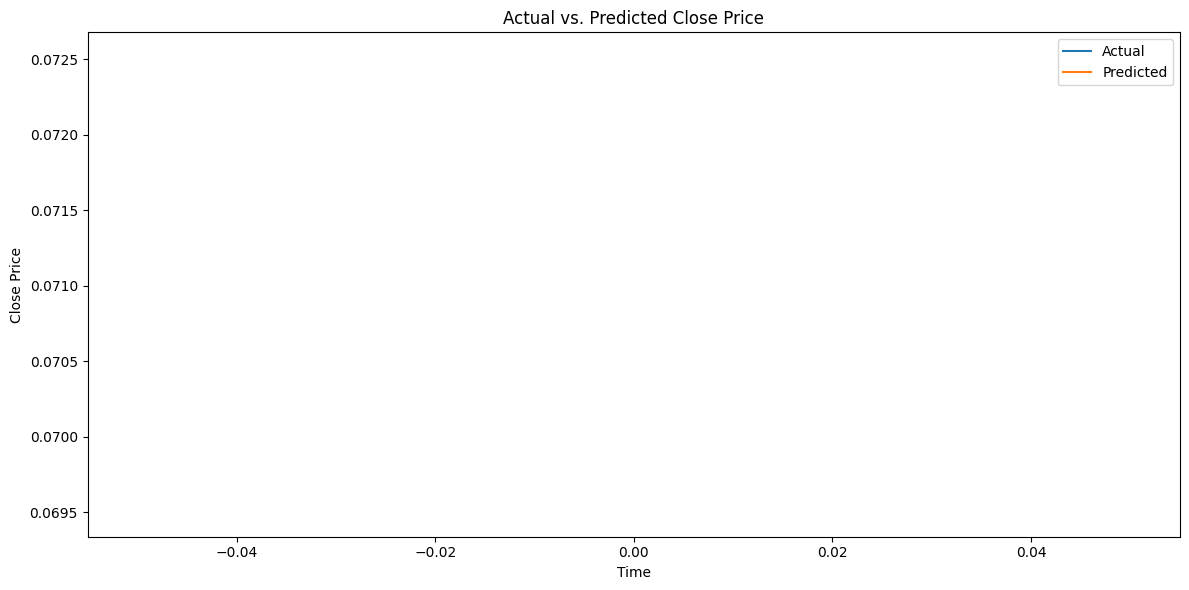

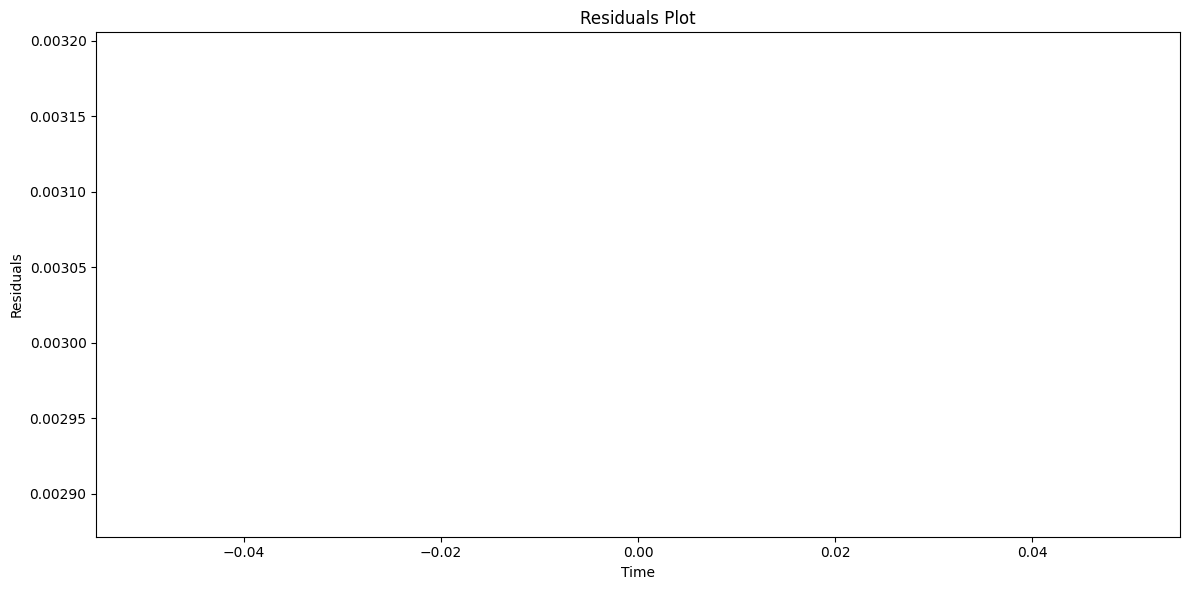

In [ ]:
#prediction and plot
y_pred = model_best.predict(X_shaped_test).flatten()
plt.figure(figsize=(12, 6))
plt.plot(y_seq_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.tight_layout()
plt.savefig('prediction_plot_df_2.png')
plt.show()

#plot residuals
residuals = y_seq_test - y_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.savefig('residuals_plot_df_2.png')
plt.show()

In [ ]:
#save model and parameters
with open('model_best_lstm_df_2.pkl', 'wb') as f:
    joblib.dump(model_best, f)

with open('best_params_lstm_df_2.pkl', 'wb') as f:
    joblib.dump(best_params, f)

## Mutlivariate Approach

The above implementation focuses on Past Close Price alone to determine future close prices. However, as seen in other implementations, external factors such as twitter sentimenet and the values of other stocks can play a crucial role in influencing Bitcoin pricing. This nuanced nature needs to be captured in the LSTM and this can be done using a multivariate approach.

The main difference between the above univariate model and the multivariate, is the design of the 'hist' function that will include a range of features/predictiors for the previous 'n' data points.

In [ ]:
# creating the split or history for each point - multivariate
gc.collect()
def hist_multi(sequence, n_steps):
  """
  Creates Input/Target Sequenecs for the Multivariate Time Series Approach
  """
  X, y = list(), list()
  for i in range(len(sequence) - n_steps):
    seq_x = sequence[i:i + n_steps, :] #seq of features from i to i +n_steps
    seq_y = sequence[i + n_steps, 0] #asserting that the BTC Close Price is the first column
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y) #np arrays for easier use in model an computation

In [ ]:
# apply to data - all but year
gc.collect()
multivariate_data_multi = train_df_1[['Close_UTC_00', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']].to_numpy()
#split into samples
n_steps = 7 #to match nair implementation
X_seq, y_seq = hist_multi(multivariate_data_multi, n_steps)

#view to check
print(X_seq[:5])
print(y_seq[:5])

[[[ 0.44860119  0.42941712  0.52582813  0.80831783  0.17255869
    0.47697177  0.51747078  0.5334851   0.22091191  0.34554715
    0.          1.          8.        ]
  [ 0.42966349  0.42941712  0.52582813  0.80831783  0.15056097
    0.44860119  0.52192343  0.55139899  0.17255869  0.3973113
    1.          1.          9.        ]
  [ 0.45300106  0.42959927  0.52304369  0.77870378  0.26588812
    0.42966349  0.47697177  0.54115758  0.15056097  0.22091191
    0.63625285  1.         10.        ]
  [ 0.44592932  0.45591985  0.54339894  0.82814144  0.25538158
    0.45300106  0.44860119  0.53133419  0.26588812  0.17255869
    0.47168271  1.         11.        ]
  [ 0.46686691  0.46001821  0.54949592  0.81790598  0.33337254
    0.44592932  0.42966349  0.51747078  0.25538158  0.15056097
    0.34554715  1.         12.        ]
  [ 0.48195705  0.42959927  0.51833893  0.79173072  0.38016271
    0.46686691  0.45300106  0.52192343  0.33337254  0.26588812
    0.3973113   1.         13.        ]
  [ 0

Next define custom fit and predict functions to match the rolling_cv implementation

In [ ]:
def lstm_multivariate_fit(model_dict, X_train, y_train, n_steps=n_steps, epochs=50, dropout_rate=0.1, learning_rate=0.01):
  """
  Multivariate LSTM using all features as indicator

  """
  #X_train is already in correct shape so we just need to define n_features
  n_features = X_train.shape[2] # as (sample, window, n_features)


  #Model Implementation:
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features),  return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(25, activation='relu')) #(1,25)
  model.add(Dense(50, activation='relu')) #(50)
  model.add(Dropout(dropout_rate))
  model.add(Dense(1))#(1)
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='mae')

  #fit the model
  model.fit(X_train, y_train, epochs=epochs, verbose=0)
  #save model features
  model_dict['model'] = model
  model_dict['n_steps'] = n_steps
  model_dict['n_features'] = n_features
  return model_dict

def lstm_multivariate_predict(model_dict, X_test):
  """
  Multivariate LSTM using all features as indicators
  """
  model = model_dict['model']
  n_steps = model_dict['n_steps']
  #make a prediction
  y_pred = model.predict(X_test, verbose=0).flatten()

  return y_pred

In [ ]:
#apply using rolling cv
gc.collect()
model_dict = {}
results = rolling_cv(
    X_seq, y_seq,
    model=model_dict,
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: lstm_multivariate_fit(model, X_train, y_train, n_steps=n_steps, epochs=50),
    custom_predict = lambda model, X_test: lstm_multivariate_predict(model, X_test),
    return_preds=True
)
#print results
print(f"MAE: {results['mae']}")
print(f"RMSE: {results['rmse']}")
print(f"SMAPE: {results['smape']}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:28:14] Energy consumed for RAM : 0.002290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:28:14] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:28:14] Energy consumed for All CPU : 0.009736 kWh
[codecarbon INFO @ 00:28:14] Energy consumed for all GPUs : 0.007839 kWh. Total GPU Power : 34.767936788689894 W
[codecarbon INFO @ 00:28:14] 0.019865 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instea

MAE: 0.12015817032503584
RMSE: 0.13524729370237726
SMAPE: 52.59432317458786%


## Hyperparameter tuning using optuna

In [ ]:
#tune dropout rate, learning rate, metric to optimize adam on, num of epochs
gc.collect()
def objective(trial):
  #tune the hyperparams:
  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
  learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
  epochs = trial.suggest_int('epochs', 40, 80)

  model_dict = {}
  results = rolling_cv(
    X_seq, y_seq,
    model=model_dict,
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: lstm_multivariate_fit(model, X_train, y_train, n_steps=n_steps, epochs=epochs, learning_rate=learning_rate, dropout_rate=dropout_rate),
    custom_predict = lambda model, X_test: lstm_multivariate_predict(model, X_test),
    return_preds=False
)
  return results['mae']
#initialzing
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

#save best params
best_params = study.best_params
print("Best Hyperparameters:")
print(best_params)

[I 2025-04-20 00:29:33,012] A new study created in memory with name: no-name-3a2e9a06-5c00-4fe4-82c4-055577d36a0a
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:29:44] Energy consumed for RAM : 0.002540 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:29:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:29:44] Energy consumed for All CPU : 0.010798 kWh
[codecarbon INFO @ 00:29:44] Energy consumed for all GPUs : 0.008712 kWh. Total GPU Power : 34.875653782786756 W
[codecarbon INFO @ 00:29:44] 0.022050 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a

Best Hyperparameters:
{'dropout_rate': 0.3692397320949248, 'learning_rate': 0.0033159959491773578, 'epochs': 51}


In [ ]:
#fitting best model
multivariate_data_test = refit_df_1[['Close_UTC_00', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']].to_numpy()
#split samples
n_steps = 7 #to match nair implementation
X_seq_test, y_seq_test = hist_multi(multivariate_data_test, n_steps)


#buidling best model
#X_shaped_test = X_seq_test.reshape((X_seq_test.shape[0], n_steps, 1))
gc.collect()
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
#metric = best_params['metric']
epochs = best_params['epochs']

#buidling best model
n_features = X_seq_test.shape[2]
#X_shaped = X_seq.reshape((X_seq.shape[0], n_steps, 1))
model_best = Sequential()
model_best.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features),  return_sequences=True)) #(7,50)
model_best.add(Dropout(dropout_rate))
model_best.add(LSTM(25, activation='relu')) #(1,25)
model_best.add(Dense(50, activation='relu')) #(50)
model_best.add(Dropout(dropout_rate))
model_best.add(Dense(1))#(1)
optimizer = Adam(learning_rate=learning_rate)
model_best.compile(optimizer=optimizer, loss='mae')

#fit
best_results = model_best.fit(X_seq_test, y_seq_test, epochs=epochs, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:33:44] Energy consumed for RAM : 0.003207 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:33:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:33:44] Energy consumed for All CPU : 0.013630 kWh
[codecarbon INFO @ 00:33:44] Energy consumed for all GPUs : 0.011069 kWh. Total GPU Power : 35.406740628166695 W
[codecarbon INFO @ 00:33:44] 0.027906 kWh of electricity used since the beginning.


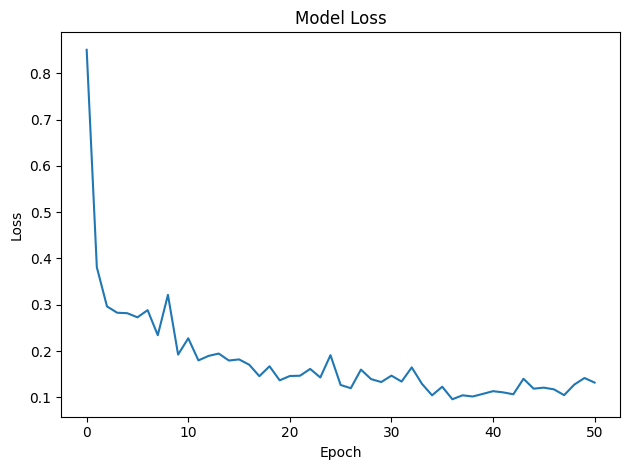

In [ ]:
#visualizations
#training loss
plt.plot(best_results.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('training_loss_plot_multi_df_1.png')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 884ms/step


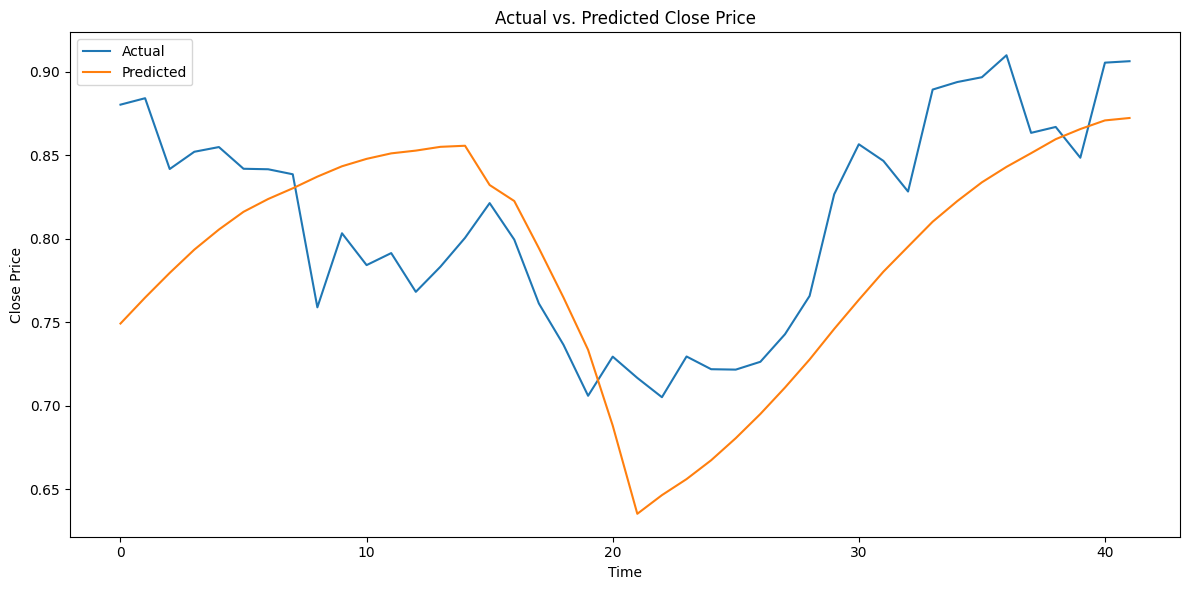

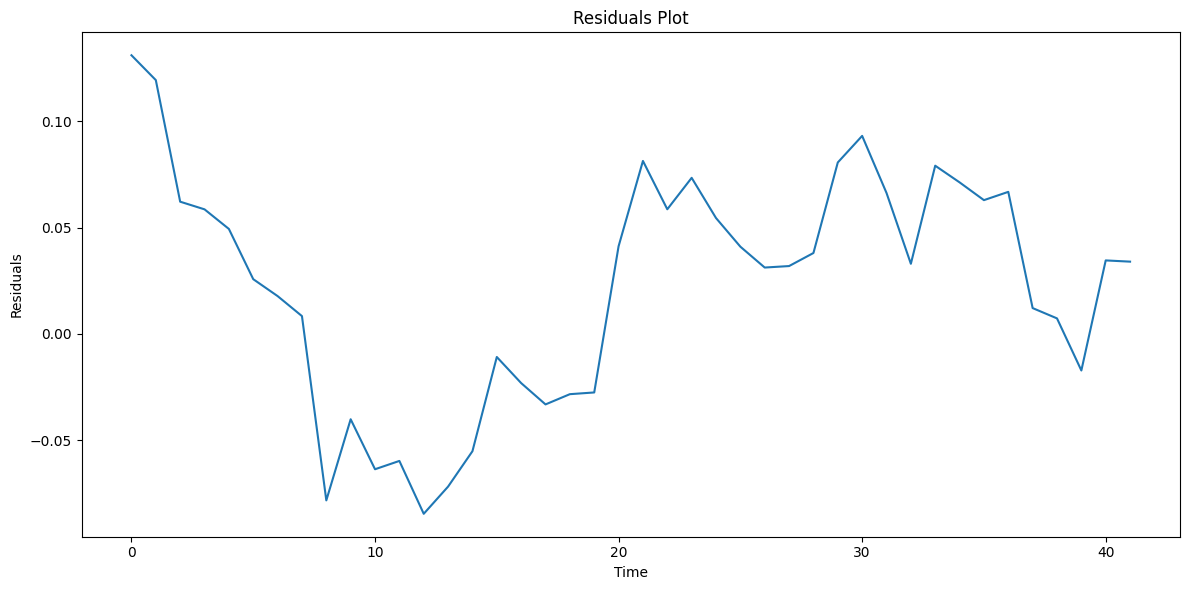

In [ ]:
#prediction and plot
y_pred = model_best.predict(X_seq_test).flatten()
plt.figure(figsize=(12, 6))
plt.plot(y_seq_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.tight_layout()
plt.savefig('prediction_plot_multi_df_1.png')
plt.show()

#plot residuals
residuals = y_seq_test - y_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.savefig('residuals_plot_multi_df_1.png')
plt.show()

In [ ]:
#save model and parameters
with open('model_best_lstm_multi_df_1.pkl', 'wb') as f:
    joblib.dump(model_best, f)
#model_best.save('model_best_lstm_multi_df_1.h5')
with open('best_params_lstm_multi_df_1.pkl', 'wb') as f:
    joblib.dump(best_params, f)

# Multivariate Implementation for Dataset 2


In [ ]:
# apply to data - all but year
gc.collect()
multivariate_data_multi_2 = train_df_2[['Close_UTC_00', 'avg_sentiment_score','Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']].to_numpy()
#split into samples
n_steps = 7 #to match nair implementation
X_seq, y_seq = hist_multi(multivariate_data_multi_2, n_steps)

#view to check
print(X_seq[:5])
print(y_seq[:5])

[[[ 0.45744274  0.2532825   0.40783242  0.47974076  0.76652642
    0.57091607  0.47281696  0.47245206  0.44592932  0.70430662
    0.73410428  0.          1.         18.        ]
  [ 0.44733754  0.20857073  0.37531876  0.45698512  0.75641233
    0.50771359  0.45744274  0.47721196  0.46686691  0.57091607
    0.75471484  1.          1.         19.        ]
  [ 0.45413983  0.19987842  0.35965392  0.43298128  0.76498908
    0.54185453  0.44733754  0.47281696  0.48195705  0.50771359
    0.70430662  1.          1.         20.        ]
  [ 0.46858394  0.17053793  0.34052823  0.39087854  0.64503601
    0.60066217  0.45413983  0.45744274  0.46689478  0.54185453
    0.57091607  0.70518166  1.         21.        ]
  [ 0.3899737   0.17229299  0.34052823  0.39087854  0.64503601
    0.35362527  0.46858394  0.44733754  0.47245206  0.60066217
    0.50771359  0.73410428  1.         22.        ]
  [ 0.32220542  0.17229299  0.34052823  0.39087854  0.64503601
    0.26106454  0.3899737   0.45413983  0.47721

In [ ]:
#apply using rolling cv
gc.collect()
model_dict = {}
results = rolling_cv(
    X_seq, y_seq,
    model=model_dict,
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: lstm_multivariate_fit(model, X_train, y_train, n_steps=n_steps, epochs=50),
    custom_predict = lambda model, X_test: lstm_multivariate_predict(model, X_test),
    return_preds=True
)
#print results
print(f"MAE: {results['mae']}")
print(f"RMSE: {results['rmse']}")
print(f"SMAPE: {results['smape']}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:34:29] Energy consumed for RAM : 0.003332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:34:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:34:29] Energy consumed for All CPU : 0.014161 kWh
[codecarbon INFO @ 00:34:29] Energy consumed for all GPUs : 0.011515 kWh. Total GPU Power : 35.85141393794325 W
[codecarbon INFO @ 00:34:29] 0.029008 kWh of electri

MAE: 0.06573786970014536
RMSE: 0.08009844561690402
SMAPE: 17.264703111684202%


In [ ]:
#tune dropout rate, learning rate, metric to optimize adam on, num of epochs
gc.collect()
def objective(trial):
  #tune the hyperparams:
  dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
  learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
  epochs = trial.suggest_int('epochs', 40, 80)

  model_dict = {}
  results = rolling_cv(
    X_seq, y_seq,
    model=model_dict,
    model_type='custom',
    n_splits=5,
    custom_fit = lambda model, X_train, y_train: lstm_multivariate_fit(model, X_train, y_train, n_steps=n_steps, epochs=epochs, learning_rate=learning_rate, dropout_rate=dropout_rate),
    custom_predict = lambda model, X_test: lstm_multivariate_predict(model, X_test),
    return_preds=False
)
  return results['mae']
#initialzing
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

#save best params
best_params = study.best_params
print("Best Hyperparameters:")
print(best_params)

[I 2025-04-20 00:35:24,822] A new study created in memory with name: no-name-82763fd1-7bbd-41b0-acbb-79410ccc079b
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:35:29] Energy consumed for RAM : 0.003498 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:35:29] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:35:29] Energy consumed for All CPU : 0.014870 kWh
[codecarbon INFO @ 00:35:29] Energy consumed for all GPUs : 0.012109 kWh. Total GPU Power : 35.933096603967705 W
[codecarbon INFO @ 00:35:29] 0.030476 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a

Best Hyperparameters:
{'dropout_rate': 0.19814122795755337, 'learning_rate': 0.0010157543145667685, 'epochs': 75}


In [ ]:
#fitting best model
multivariate_data_test = refit_df_2[['Close_UTC_00','avg_sentiment_score', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']].to_numpy()
#split samples
n_steps = 7 #to match nair implementation
X_seq_test, y_seq_test = hist_multi(multivariate_data_test, n_steps)


#buidling best model
gc.collect()
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
epochs = best_params['epochs']

#buidling best model
n_features = X_seq_test.shape[2]#have to redo because we have one extra feature with this dataset i.e. twitter sent

#buidling best model

model_best = Sequential()
model_best.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features),  return_sequences=True)) #(7,50)
model_best.add(Dropout(dropout_rate))
model_best.add(LSTM(25, activation='relu')) #(1,25)
model_best.add(Dense(50, activation='relu')) #(50)
model_best.add(Dropout(dropout_rate))
model_best.add(Dense(1))#(1)
optimizer = Adam(learning_rate=learning_rate)
model_best.compile(optimizer=optimizer, loss='mae')

#fit
best_results = model_best.fit(X_seq_test, y_seq_test, epochs=epochs, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 00:37:44] Energy consumed for RAM : 0.003873 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:37:44] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:44] Energy consumed for All CPU : 0.016462 kWh
[codecarbon INFO @ 00:37:44] Energy consumed for all GPUs : 0.013439 kWh. Total GPU Power : 35.88696929555248 W
[codecarbon INFO @ 00:37:44] 0.033774 kWh of electricity used since the beginning.


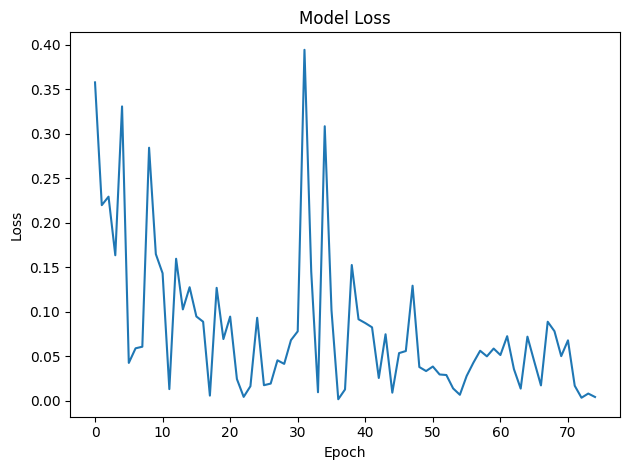

In [ ]:
#visualizations
#training loss
plt.plot(best_results.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('training_loss_plot_multi_df_2.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


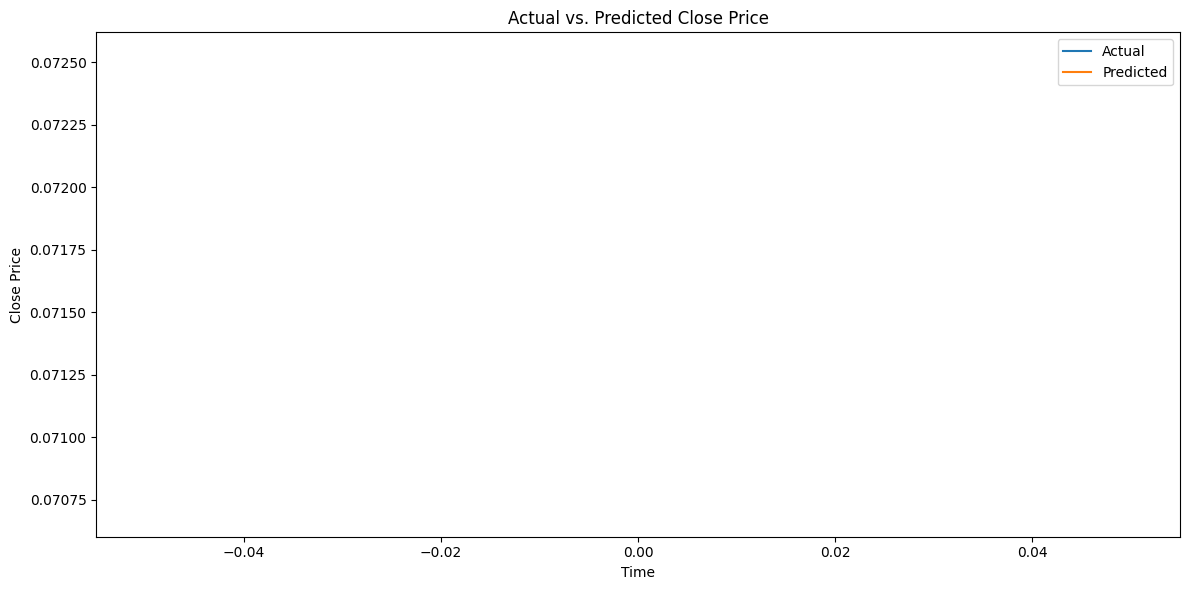

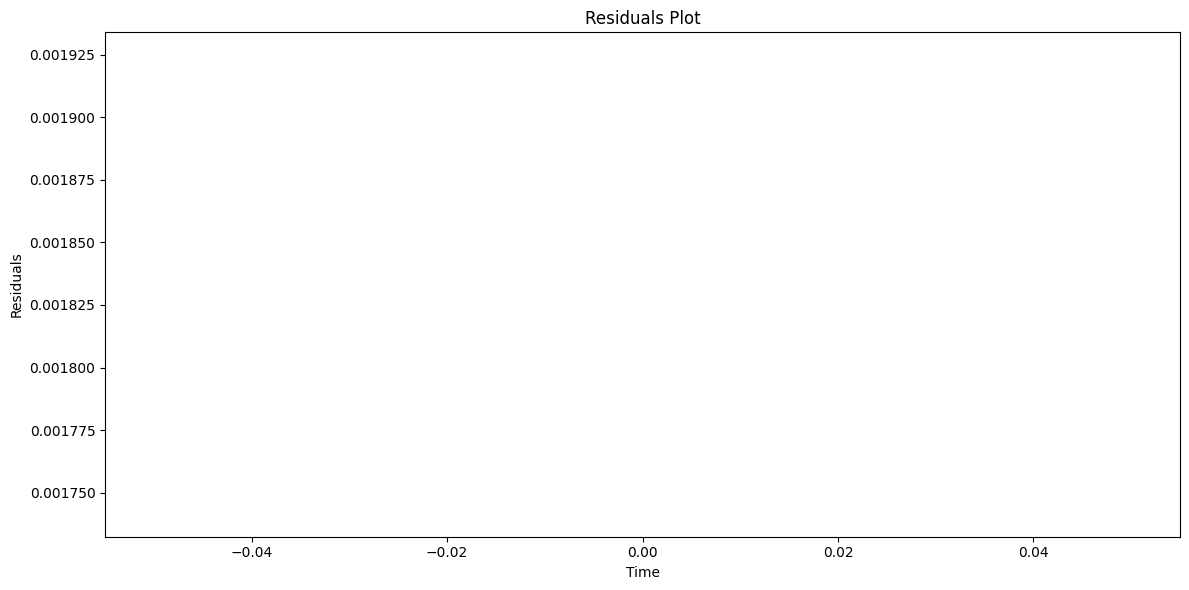

In [ ]:
#prediction and plot
y_pred = model_best.predict(X_seq_test).flatten()
plt.figure(figsize=(12, 6))
plt.plot(y_seq_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price')
plt.legend()
plt.tight_layout()
plt.savefig('prediction_plot_multi_df_2.png')
plt.show()

#plot residuals
residuals = y_seq_test - y_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.tight_layout()
plt.savefig('residuals_plot_multi_df_2.png')
plt.show()

In [ ]:
#save model and parameters
with open('model_best_lstm_multi_df_2.pkl', 'wb') as f:
    joblib.dump(model_best, f)

with open('best_params_lstm_multi_df_2.pkl', 'wb') as f:
    joblib.dump(best_params, f)

In [ ]:
#zip results all results images, params, models etc
tracker.stop()
with zipfile.ZipFile('results_lstm.zip', 'w') as zipf:
    zipf.write('training_loss_plot_df_1.png')
    zipf.write('training_loss_plot_df_2.png')
    zipf.write('training_loss_plot_multi_df_1.png')
    zipf.write('training_loss_plot_multi_df_2.png')
    zipf.write('prediction_plot_df_1.png')
    zipf.write('prediction_plot_df_2.png')
    zipf.write('prediction_plot_multi_df_1.png')
    zipf.write('prediction_plot_multi_df_2.png')
    zipf.write('residuals_plot_df_1.png')
    zipf.write('residuals_plot_df_2.png')
    zipf.write('residuals_plot_multi_df_1.png')
    zipf.write('residuals_plot_multi_df_2.png')
    zipf.write('model_best_lstm_df_1.pkl')
    zipf.write('model_best_lstm_df_2.pkl')
    zipf.write('model_best_lstm_multi_df_1.pkl')
    zipf.write('model_best_lstm_multi_df_2.pkl')
    zipf.write('best_params_lstm_df_1.pkl')
    zipf.write('best_params_lstm_df_2.pkl')
    zipf.write('best_params_lstm_multi_df_1.pkl')
    zipf.write('best_params_lstm_multi_df_2.pkl')
    zipf.write('emissions_lstm.csv')

files.download('results_lstm.zip')

[codecarbon INFO @ 00:37:55] Energy consumed for RAM : 0.003902 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 00:37:55] Delta energy consumed for CPU with constant : 0.000126 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:55] Energy consumed for All CPU : 0.016588 kWh
[codecarbon INFO @ 00:37:55] Energy consumed for all GPUs : 0.013545 kWh. Total GPU Power : 35.585872882575416 W
[codecarbon INFO @ 00:37:55] 0.034035 kWh of electricity used since the beginning.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>